# Gradient Descent and It's Variants
Gradient Descent is the bread and butter of any Deep Learning model's training process. Gradient Descent is an optimization algorithm that basically depends on the computational graph to be completely differentiable! So how does it work?
* Gradient descent depends on a scalar values loss function (a metric that represents how worst our model performs for given batch of data).
* Given a batch of data we compute our predictions which are passed into the loss function along with the true values. This loss function is thus differentiable w.r.t. the weights of the computational graph.
* But what's with being differentiable? We know that we need to minimize the value of this loss function and thus we want to update weights on each iteration in such a manner that our loss function is minimum.
$$\min_\theta J(x, y; \theta)$$
* Differentiation of loss function w.r.t to weights gives us a pretty good idea of direction in which the loss function increases. Going in opposite direction thus results in reduction of value of our loss function.

|![Gradient Descent](https://predictiveprogrammer.com/wp-content/uploads/2018/06/w_vs_jw.png)|
|:------------------------------------------------------------------------------------------:|
| Gradient Descent. *Source: https://predictiveprogrammer.com/convolutional-neural-networks-introduction/*|

**Tl;dr** for above is - we differentiate loss function w.r.t to weights which inturn gives us direction in which loss increases and hence we move weights in opposite direction!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

In [2]:
tf.enable_eager_execution()

## Our Dataset
To keep it simple we will be creating a dataset for following equation:

$$y = 2x + 3 + noise$$

Then we will be applying gradient descent and its variants to our dataset!

In [3]:
X = np.random.randn(2000, 1)
y = X * 2 + 3 + np.random.randn(*X.shape)

X.shape, y.shape

((2000, 1), (2000, 1))

## Some Helper Functions
We will be needing weights and biases when we will go through working of every optimizer. Let's make a function to ease this out for us!

In [4]:
def get_weights():
    w = tf.contrib.eager.Variable(tf.random_normal([1]))
    b = tf.contrib.eager.Variable(tf.zeros([1]))
    return w, b

We will need loss function as every optimizer optimizes loss function to be minimum!

In [5]:
def predict(inputs, weight, bias):
    return inputs * weight + bias

def loss(inputs, weight, bias, outputs):
    error = predict(inputs, weight, bias) - outputs
    return tf.reduce_mean(tf.square(error))

This function will help us visualize the performance of our loss function.

In [6]:
def visualize(history):
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

Lastly we will need to compute gradients of w and b for every optimizer so let's define a function for it.

In [7]:
def grads(w, b):
    with tf.GradientTape() as tape:
        l = loss(X, w, b, y)
    dw, db = tape.gradient(l, [w, b])
    return l, dw, db

We will be needing epochs and learning rate so we will use equal number of constants and learning rate for every optimizer. This will help us see which optimizer was able to perform best in same conditions!

In [8]:
epochs = 1000
lr = 0.001

## Vanilla Gradient Descent
First let's have a look at simple gradient descent. So we will be using TensorFlow to compute gradients and will be subtracting them off from the weights and biases!

* Step 1: Get Weights
* Step 2: Calculate loss
* Step 3: Calculate gradient of loss w.r.t. w and b
* Step 4: Subtract respective gradients from w and b

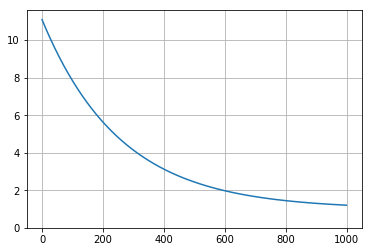

Final loss: 1.203
W = [1.8037035], B = [2.5633972]


In [9]:
w, b = get_weights()                        # Step 1 Get Weights

l_history = []

for epoch in range(epochs):
    l, dw, db = grads(w, b)                # Step 2 and 3 Calculate loss and its gradients w.r.t w and b
    l_history.append(l.numpy())
    w.assign_sub(dw * lr)                  # Step 4 subtract gradients from w 
    b.assign_sub(db * lr)                  # Step 4 subtract gradients from b
    if epoch % 20 == 0:
        visualize(l_history)

visualize(l_history)
print("Final loss: {:.3f}".format(loss(X, w, b, y)))
print("W = {}, B = {}".format(w.numpy(), b.numpy()))

This was all cool but TensorFlow gives us an even better option of inbuilt Gradient Descent Optimizer. But why do we need an inbuilt optimizer? Consider having a model with millions of parameters, it is better to give a list of variables and their gradients to an object to do the heavy lifting else we will have to call `assign_sub()` for all of them. Let's check it out!

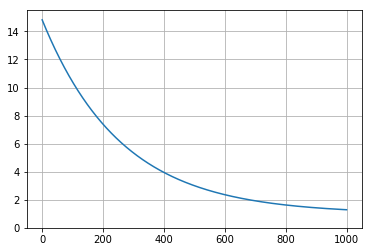

Final loss: 1.286
W = [1.6600277], B = [2.5502489]


In [10]:
tf.reset_default_graph()

w, b = get_weights()                                      # Step 1 Get weights

l_history = []

optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
for epoch in range(epochs):
    l, dw, db = grads(w, b)                              # Step 2 and 3 Calculate loss and its gradients w.r.t w and b
    l_history.append(l.numpy())
    optimizer.apply_gradients(zip([dw, db], [w, b]))     # Step 4
    if epoch % 20 == 0:
        visualize(l_history)

visualize(l_history)
print("Final loss: {:.3f}".format(loss(X, w, b, y)))
print("W = {}, B = {}".format(w.numpy(), b.numpy()))

Cool isn't it!! Consider Having millions of 

Let's discuss a variant of Gradient Descent that gives us a momentum in the direction of reducing loss. Like an ommph to our model!!

## Gradient Descent with Momentum
Momentum helps Gradient Descent to move in a particular direction and reduces oscillations. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.

Its update rule is as follow:

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$
$$ w_t = w_{t-1} - \nu_t$$

![](../images/sgd.png)

So the steps are:

* Step 1: Get Weights
* Step 2: Calculate loss
* Step 3: Calculate gradient of loss w.r.t. w and b
* Step 4: Calculate nu at time step t for w and b
* Step 5: Subtract respective nu values from w and b

Let's build it without built in optimizer first!

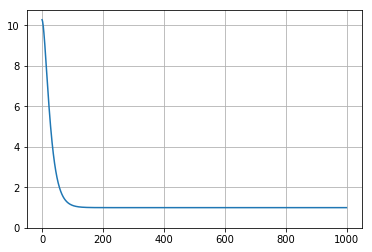

Final loss: 0.996
W = [1.9971349], B = [2.982254]


In [11]:
tf.reset_default_graph()

w, b = get_weights()                          # Step 1 Get weights

nu_w = tf.contrib.eager.Variable(tf.zeros_like(w))
nu_b = tf.contrib.eager.Variable(tf.zeros_like(b))

momentum = 0.9

l_history = []

for epoch in range(epochs):
    l, dw, db = grads(w, b)                   # Step 2 and 3 Calculate loss and its gradients w.r.t w and b
    l_history.append(l.numpy())
    nu_w.assign(nu_w * momentum + lr * dw)    # Step 4 calculate nu at time t for w
    nu_b.assign(nu_b * momentum + lr * db)    # Step 4 calculate nu at time t for b
    w.assign_sub(nu_w)                        # Step 5 subtract gradients from w 
    b.assign_sub(nu_b)                        # Step 5 subtract gradients from b
    if epoch % 20 == 0:
        visualize(l_history)

visualize(l_history)
print("Final loss: {:.3f}".format(loss(X, w, b, y)))
print("W = {}, B = {}".format(w.numpy(), b.numpy()))

Now for the built-in Momentum based Gradient Descent Optimizer!

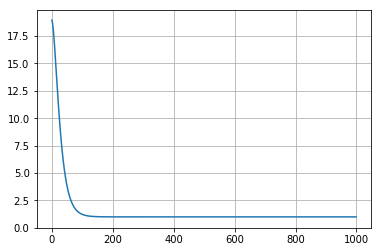

Final loss: 0.996
W = [1.9971349], B = [2.982254]


In [12]:
tf.reset_default_graph()

w, b = get_weights()                                      # Step 1 Get weights

l_history = []

optimizer = tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9)
for epoch in range(epochs):
    l, dw, db = grads(w, b)                              # Step 2 and 3 Calculate loss and its gradients w.r.t w and b
    l_history.append(l.numpy())
    optimizer.apply_gradients(zip([dw, db], [w, b]))     # Step 4 and 5
    if epoch % 20 == 0:
        visualize(l_history)

visualize(l_history)
print("Final loss: {:.3f}".format(loss(X, w, b, y)))
print("W = {}, B = {}".format(w.numpy(), b.numpy()))

Just look at how fast the optimizer converged to a lower value of loss. This means we can reduce the training epochs and in turn training time significantly!

## RMSprop
RMSprop uses squared gradients to adjust learning rate. As we know learning rate is a crucial part of any training process. If we adjust learning rate to with increasing epoch we can specifically target an optimal value. We can do this without risking divergence from optimal value as we will slowly reduce the learning rate.

Update rules:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

So, steps to follow are:
* Step 1: Get Weights
* Step 2: Calculate loss
* Step 3: Calculate gradient of loss w.r.t. w and b
* Step 4: Calculate squared gradients moving average till current time step
* Step 5: Subtract respective gradients from w and b while decaying learning rate using root of squared moving average of gradients

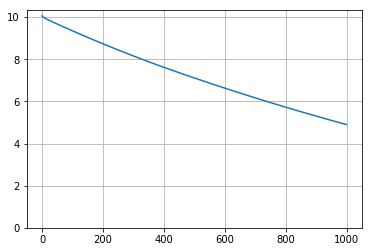

Final loss: 4.896
W = [1.9111573], B = [1.0055565]


In [15]:
tf.reset_default_graph()

w, b = get_weights()                                             # Step 1 Get Weights

alpha = 0.9
g2_w = tf.contrib.eager.Variable(tf.zeros_like(w))
g2_b = tf.contrib.eager.Variable(tf.zeros_like(b))
eps = 1e-8

l_history = []

for epoch in range(epochs):
    l, dw, db = grads(w, b)                                      # Step 2 and 3 Calculate loss and its gradients w.r.t w and b
    l_history.append(l.numpy())

    g2_w.assign(alpha * g2_w + (1 - alpha) * dw ** 2)            # Step 4 find moving average of squared gradients of w
    g2_b.assign(alpha * g2_b + (1 - alpha) * db ** 2)            # Step 4 find moving average of squared gradients of b

    w.assign_sub(lr / tf.sqrt(g2_w + eps) * dw)                  # Step 5 subtract gradients from w using decayed lr 
    b.assign_sub(lr / tf.sqrt(g2_b + eps) * db)                  # Step 5 subtract gradients from b using decayed lr
    if epoch % 20 == 0:
        visualize(l_history)

visualize(l_history)
print("Final loss: {:.3f}".format(loss(X, w, b, y)))
print("W = {}, B = {}".format(w.numpy(), b.numpy()))

Now let's see inbuilt RMSprop optimizer of TensorFlow!!

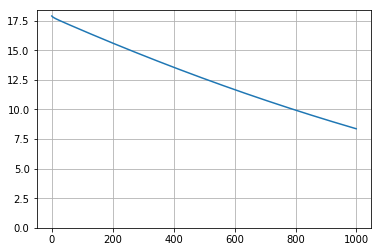

Final loss: 8.365
W = [0.0701846], B = [1.0047008]


In [16]:
tf.reset_default_graph()

w, b = get_weights()                                      # Step 1 Get weights

l_history = []

optimizer = tf.train.RMSPropOptimizer(learning_rate=lr, decay=0.9, epsilon=1e-8)
for epoch in range(epochs):
    l, dw, db = grads(w, b)                              # Step 2 and 3 Calculate loss and its gradients w.r.t w and b
    l_history.append(l.numpy())
    optimizer.apply_gradients(zip([dw, db], [w, b]))     # Step 4 and 5
    if epoch % 20 == 0:
        visualize(l_history)

visualize(l_history)
print("Final loss: {:.3f}".format(loss(X, w, b, y)))
print("W = {}, B = {}".format(w.numpy(), b.numpy()))

So far, we have seen three optimizers in action there are many other built-in Optimizers in the TensorFlow library. Check them out and note their behavior understand which is useful for which purpose.